## Colorado Oil & Gas Drilling Permits
##### Investigating how the number of Drilling permits changed over the past year (June 2016-June 2017)

* Has the new administration had an effect on the permit approval process?
* Has the number of permit requests increased?

In [29]:
from __future__ import division
import pandas as pd
import numpy as np
from datetime import timedelta
import pymc3 as pm
import theano.tensor as tt
import matplotlib.pyplot as plt
import matplotlib as mpl
from pylab import rcParams
from matplotlib.ticker import AutoMinorLocator

%matplotlib inline

#### Data Import

In [3]:
# Import Colorado Oil & Gas Well historical permits approved 1/1/1898?? - 8/28/2017
# http://cogcc.state.co.us/data.html#/cogis
df_wells = pd.read_csv("data/older_well_permits_clean.csv")
df_wells['permit_date'] = pd.to_datetime(df_wells['permit_date'])

df_wells.sample(5)

,Unnamed: 0,facility_id_API,facility_type,facility_name,facility_num,field_name,field_num,county,coord,operator_name,operator_num,well_status,permit_date
19433,19433,05-045-11704,WELL,CLOUGH,RWF 431-22,RULISON,75400.0,GARFIELD,045NWNE 22 6S 94W 6,TEP ROCKY MOUNTAIN LLC,96850.0,PR,2006-09-14
106803,106803,05-125-09588,WELL,FITCH,12-9 5N46W,PHUMA,68650.0,YUMA,125SWNW 9 5N 46W 6,AUGUSTUS ENERGY RESOURCES LLC,10489.0,PR,2005-11-25
14398,14398,05-045-10835,WELL,DAYBREAK FEDERAL,30-2(PB30),PARACHUTE,67350.0,GARFIELD,045NWNE 30 7S 95W 6,ENCANA OIL & GAS (USA) INC,100185.0,AL,2011-06-06
67318,67318,05-121-09380,WELL,KELLY A,1,DE NOVA,16450.0,WASHINGTON,121CNE 5 2S 49W 6,CITIES SERVICE OIL & GAS CORP,17250.0,PA,1981-12-04
85259,85259,05-123-31615,WELL,REI H,17-32D,WATTENBERG,90750.0,WELD,123NESW 17 3N 65W 6,KERR MCGEE OIL & GAS ONSHORE LP,47120.0,PR,2012-10-09


##  Well Status Types
AB – Abandoned wellbore/completion
	 (1) The proper plugging and abandoning of a well in compliance with all applicable
	 regulations, and the cleaning up of the wellsite to the satisfaction of any governmental body 	having jurisdiction      with respect thereto and to the reasonable satisfaction of the operator.(2) To cease efforts to find or produce          from a well or field.(3) To plug a well completion and salvage material and equipment.
AC – Active
AL – Abandoned Location
CL – Closed
	 Closed to halt production
CM – Commingled
	 Commingled flow may also describe the production of fluid from two or more separate zones
	 through a single conduit.
DA – Dry & Abandoned
DG – Drilling
DM – Domestic Well
IJ – Injecting
PA – Plugged & Abandoned
PD – Pending Injection Application
PR – Producing
RC – Recompleted
  	 An operation involving any of the following: (1) Deepening from one zone to another zone.(2) Completing well in          an additional zone. (3) Plugging back from one zone to another zone. (4) Sidetracking to purposely change the            location of the bottom of the well, but not including sidetracking for the sole purpose of bypassing obstructions        in the borehole. (5) Conversion of a service well to an oil or gas well in a different zone.(6) Conversion of an        oil or gas well to a service well in a different zone.
SI – Shut In 
  	 A well which is capable of producing but is not presently producing. Reasons for a well being
	 shut in may be lack of equipment, market or other.
SU – Suspended
TA – Temporarily Abandoned
WO – Waiting on Completion
XX – Permitted Well Location

In [5]:
print("Min date of permitted wells: {}".format(df_wells['permit_date'].min()))
print("Max date of permitted wells: {}".format(df_wells['permit_date'].max()))

Min date of permitted wells: 1898-01-01 00:00:00
Max date of permitted wells: 2106-07-12 00:00:00


In [12]:
# Examining max dates. '2106-07-12' looks like a typo for 2016.  Will fix it.
sorted(df_wells['permit_date'], reverse=True)[0:10]

[Timestamp('2106-07-12 00:00:00'),
 Timestamp('2017-09-03 00:00:00'),
 Timestamp('2017-09-02 00:00:00'),
 Timestamp('2017-09-02 00:00:00'),
 Timestamp('2017-09-01 00:00:00'),
 Timestamp('2017-09-01 00:00:00'),
 Timestamp('2017-08-31 00:00:00'),
 Timestamp('2017-08-31 00:00:00'),
 Timestamp('2017-08-31 00:00:00'),
 Timestamp('2017-08-31 00:00:00')]

In [14]:
# Double checking '2106-07-12' permit date entry
df_wells[df_wells['permit_date'] == '2106-07-12']

,Unnamed: 0,facility_id_API,facility_type,facility_name,facility_num,field_name,field_num,county,coord,operator_name,operator_num,well_status,permit_date
72342,72342,05-123-39656,WELL,TWell,7,LAKE CANAL,47740.0,WELD,123SWSW 8 6N 67W 6,EXTRACTION OIL & GAS INC,10459.0,AL,2106-07-12


In [21]:
# Updating '2106-07-12 to '2016-07-12'
df_wells.loc[df_wells['permit_date'] == '2106-07-12', 'permit_date'] = pd.to_datetime('2016-07-12')

# Checking results
df_wells.iloc[72342]

Unnamed: 0                                  72342
facility_id_API                      05-123-39656
facility_type                                WELL
facility_name                               TWell
facility_num                                    7
field_name                             LAKE CANAL
field_num                                   47740
county                                       WELD
coord               123SWSW   8  6N    67W     6 
operator_name            EXTRACTION OIL & GAS INC
operator_num                                10459
well_status                                    AL
permit_date                   2016-07-12 00:00:00
Name: 72342, dtype: object

In [22]:
# Getting listing of Companies with most well permits approved in this time period
df_wells.groupby('operator_name').count()['county'].sort_values(axis=0, ascending=False)

operator_name
KERR MCGEE OIL & GAS ONSHORE LP               8203
NOBLE ENERGY INC                              7484
TEP ROCKY MOUNTAIN LLC                        5950
ENCANA OIL & GAS (USA) INC                    4834
PDC ENERGY INC                                3258
PIONEER NATURAL RESOURCES USA INC             2800
CRESTONE PEAK RESOURCES OPERATING LLC         1811
LARAMIE ENERGY LLC                            1738
FOUNDATION ENERGY MANAGEMENT LLC              1729
BP AMERICA PRODUCTION COMPANY                 1540
CHEVRON USA INC                               1535
XTO ENERGY INC                                1324
K P KAUFFMAN COMPANY INC                      1321
VANGUARD OPERATING LLC                        1133
ROSEWOOD RESOURCES INC                        1072
AUGUSTUS ENERGY RESOURCES LLC                 1039
BONANZA CREEK ENERGY OPERATING COMPANY LLC    1037
EXTRACTION OIL & GAS INC                      1006
UNKNOWN                                       1004
CAERUS PICEANCE L

In [23]:
# Getting number of wells by County
df_wells.groupby('county').count()['operator_name'].sort_values(axis=0, ascending=False)

county
WELD          32625
GARFIELD      15631
RIO BLANCO     6937
YUMA           6233
WASHINGTON     5765
LA PLATA       4549
ADAMS          4396
LAS ANIMAS     3987
LOGAN          3922
MORGAN         3026
MESA           2633
MOFFAT         2267
CHEYENNE       1808
ARAPAHOE       1340
MONTEZUMA      1070
KIOWA           986
BACA            956
BOULDER         784
LINCOLN         780
JACKSON         759
LARIMER         731
ELBERT          731
ARCHULETA       523
PHILLIPS        497
PROWERS         472
ROUTT           416
FREMONT         402
KIT CARSON      396
HUERFANO        368
SAN MIGUEL      298
BENT            271
BROOMFIELD      248
DOLORES         202
SEDGWICK        171
GUNNISON        157
DELTA           145
DENVER          132
EL PASO         129
MONTROSE         93
JEFFERSON        65
GRAND            59
PUEBLO           48
OTERO            33
CROWLEY          32
PARK             28
PITKIN           27
OURAY            26
DOUGLAS          23
SAGUACHE         18
CHAFFEE      

In [41]:
def line_plot(df, column):
    # Creating line plot
    
    # Setting up display parameters
    mpl.rc('xtick', labelsize=12)
    mpl.rc('ytick', labelsize=12)
    mpl.rcParams.update({'font.size': 15})

    # Plotting Day vs. Average Number of Patients
    x = range(len(df.groupby(column).count().index))
    y = df.groupby(column).count()['county'].values
    labels = df.groupby(column).count().index

    fig=plt.figure(figsize=(200,7));
    ax=fig.add_subplot(111);
    ax.plot(x, y, color='b', linewidth=1.5);
#     plt.xticks(np.arange(min(x), max(x)+1, 100.0), labels, rotation='vertical')
    plt.xticks(x, labels, rotation='vertical')

In [39]:
len(df_wells.groupby('permit_date').count().index)

20543

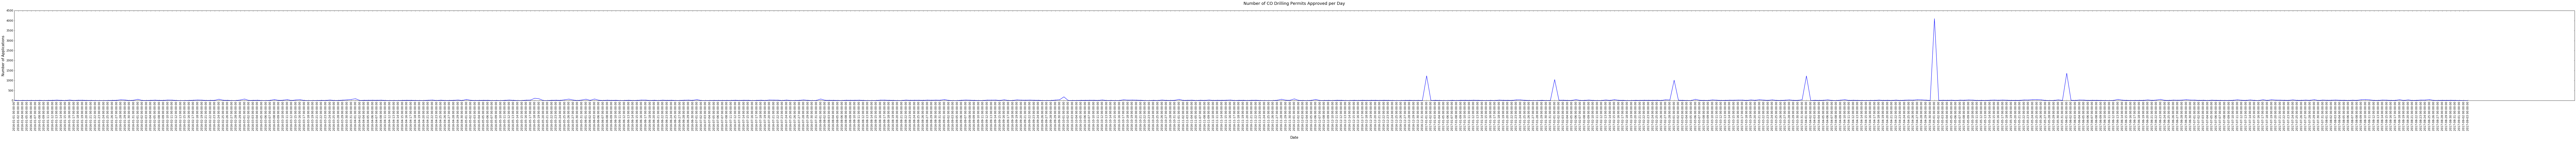

In [42]:
# Plotting the number Number of permits approved per Day in Colorado
line_plot(df_wells[df_wells['permit_date'] >= '2016-01-01'], 'permit_date')
plt.title("Number of CO Drilling Permits Approved per Day\n");
plt.ylim()
plt.xlabel('\nDate');
plt.ylabel('Number of Applications');

In [19]:
type(df_wells['status'][0])

str

In [47]:
df_wells[df_wells['permit_date'] == '2017-05-01'].groupby('county').count()

,Unnamed: 0,facility_id_API,facility_type,facility_name,facility_num,field_name,field_num,coord,operator_name,operator_num,well_status,permit_date
county,,,,,,,,,,,,
ADAMS,61,61,61,61,61,61,61,61,61,61,61,61
ARAPAHOE,8,8,8,8,8,8,8,8,8,8,8,8
ARCHULETA,1,1,1,1,1,1,1,1,1,1,1,1
BOULDER,14,14,14,14,14,14,14,14,14,14,14,14
BROOMFIELD,1,1,1,1,1,1,1,1,1,1,1,1
CHEYENNE,3,3,3,3,3,3,3,3,3,3,3,3
ELBERT,3,3,3,3,3,3,3,3,3,3,3,3
FREMONT,1,1,1,1,1,1,1,1,1,1,1,1
GARFIELD,58,58,58,58,58,58,58,58,58,58,58,58


In [54]:
df_wells[(df_wells['county'] == 'WELD') & (df_wells['permit_date'] == '2017-05-01')].groupby("well_status").count()

,Unnamed: 0,facility_id_API,facility_type,facility_name,facility_num,field_name,field_num,county,coord,operator_name,operator_num,permit_date
well_status,,,,,,,,,,,,
DG,24,24,24,24,24,24,24,24,24,24,24,24
IJ,2,2,2,2,2,2,2,2,2,2,2,2
PR,170,170,170,170,170,170,170,170,170,170,170,170
SI,3452,3452,3452,3452,3452,3452,3452,3452,3452,3452,3452,3452
TA,30,30,30,30,30,30,30,30,30,30,30,30
